In [ ]:
# 1.3. 데이터 시각화 - 주요 차트 내용 중 박스 플롯 hue 구현 예제 코드

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Seaborn 내장 데이터셋 로드
tips = sns.load_dataset('tips')

# 데이터 준비
days = tips['day'].unique()
smokers = tips['smoker'].unique()

plt.figure(figsize=(8, 5))

# 각 day와 smoker 그룹별로 박스플롯 그리기
positions = []
data_to_plot = []
pos = 1

for day in sorted(days):  # day 순서대로
    for smoker in sorted(smokers):  # smoker = No, Yes
        group = tips[(tips['day'] == day) & (tips['smoker'] == smoker)]['total_bill']
        data_to_plot.append(group)
        positions.append(pos)
        pos += 1
    pos += 1  # day 사이 간격

# 박스플롯 그리기
bp = plt.boxplot(data_to_plot, positions=positions, widths=0.6, patch_artist=True)

# 색상 채우기 (smoker 구분)
colors = ['lightblue', 'lightcoral'] * len(days)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# x축 레이블: day 가운데 배치
xticks = []
xlabels = []
for i, day in enumerate(sorted(days)):
    xticks.append((i* (len(smokers)+1)) + 1.5)  # day 그룹의 중앙
    xlabels.append(day)

plt.xticks(xticks, xlabels)
plt.xlabel("day")
plt.ylabel("total_bill")
plt.title('Total Bill Distribution by Day and Smoker')

# 범례 추가
from matplotlib.patches import Patch
legend_handles = [Patch(color='lightblue', label='No'),
                  Patch(color='lightcoral', label='Yes')]
plt.legend(handles=legend_handles, title="smoker")

plt.show()

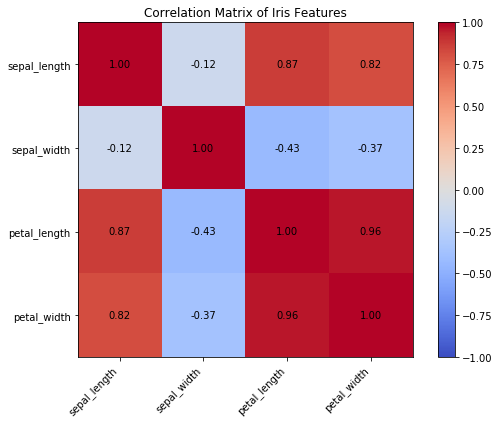

In [49]:
# 1.3. 데이터 시각화 - 주요 차트 내용 중 heatmap 예제 코드

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Seaborn 내장 데이터셋 로드
iris = sns.load_dataset('iris')

# 수치형 변수 간 상관계수 계산
corr = iris.corr()

# 히트맵 그리기
fig, ax = plt.subplots(figsize=(8, 6))

# imshow로 색상 맵 시각화
cax = ax.imshow(corr.values, cmap='coolwarm', vmin=-1, vmax=1)

# 컬럼 이름으로 x, y축 라벨 설정
ax.set_xticks(np.arange(len(corr.columns)))
ax.set_yticks(np.arange(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=45, ha='right')
ax.set_yticklabels(corr.columns)

# 각 셀에 상관계수 값 표시
for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        ax.text(j, i, f"{corr.values[i, j]:.2f}", ha='center', va='center', color='black')

# 컬러바 추가
fig.colorbar(cax)

plt.title('Correlation Matrix of Iris Features')
plt.tight_layout()
plt.show()


In [1]:
import warnings
warnings.filterwarnings('ignore')

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Seaborn 내장 'titanic' 데이터셋 사용
df = sns.load_dataset('titanic')

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.6+ KB


--- Descriptive Statistics for 'age' ---
count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: age, dtype: float64


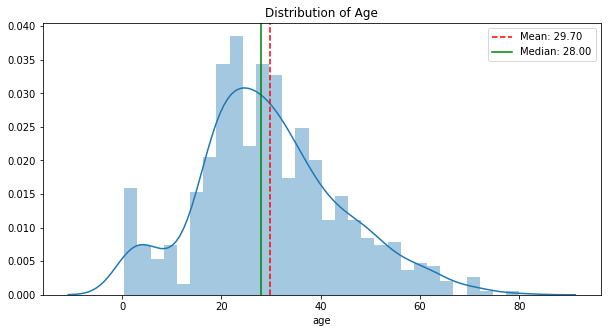

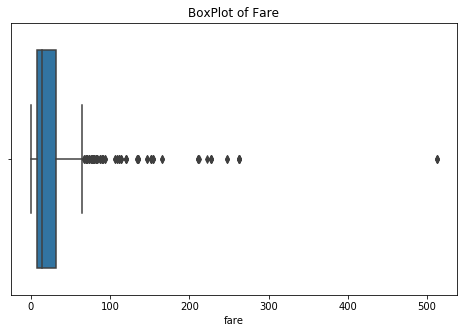

In [27]:
# 1-1. 기술 통계량 확인
print("--- Descriptive Statistics for 'age' ---")
print(df['age'].describe())

# 1-2. 분포 시각화 (히스토그램 + KDE)
plt.figure(figsize=(10, 5))
sns.distplot(df['age'].dropna(), kde=True, bins=30)
plt.title('Distribution of Age')
plt.axvline(df['age'].mean(), color='red', linestyle='--', label=f"Mean: {df['age'].mean():.2f}")
plt.axvline(df['age'].median(), color='green', linestyle='-', label=f"Median: {df['age'].median():.2f}")
plt.legend()
plt.show()

# 1-3. 박스 플롯 (이상치 확인)
plt.figure(figsize=(8, 5))
sns.boxplot(df['fare'])
plt.title("BoxPlot of Fare")
plt.show()

--- Frequency of 'pclass' ---
3    491
1    216
2    184
Name: pclass, dtype: int64

--- Ratio of 'sex' ---
male      0.647587
female    0.352413
Name: sex, dtype: float64


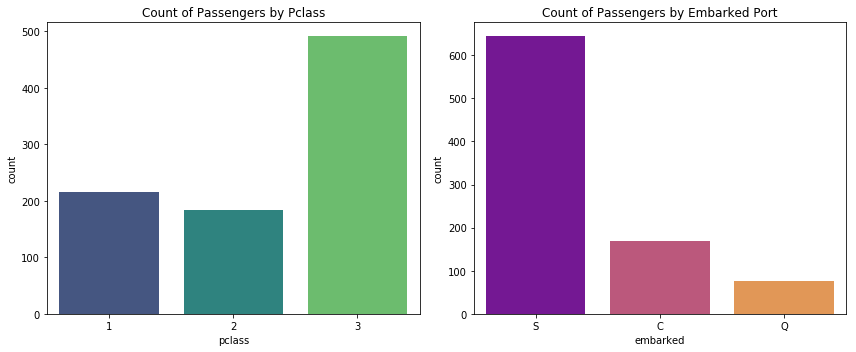

In [29]:
# 2-1. 빈도 분석
print("--- Frequency of 'pclass' ---")
print(df['pclass'].value_counts())

print("\n--- Ratio of 'sex' ---")
print(df['sex'].value_counts(normalize=True))

# 2-2. 시각화 (바 차트)
plt.figure(figsize=(12, 5))

# pclass에 대한 countplot
plt.subplot(1, 2, 1)
sns.countplot(x='pclass', data=df, palette='viridis')
plt.title('Count of Passengers by Pclass')

# embarked에 대한 countplot
plt.subplot(1, 2, 2)
sns.countplot(x='embarked', data=df, palette='plasma')
plt.title('Count of Passengers by Embarked Port')

plt.tight_layout()
plt.show()